# Телеком

Оператор связи **«Ниединогоразрыва.ком»** хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Импорт библиотек, настройки, константы

In [ ]:
import pandas as pd
from datetime import datetime
import re
import numpy as np
import warnings
import seaborn as sns
from matplotlib import pyplot as plt


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, precision_score, recall_score
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier


from catboost import CatBoostClassifier, cv, Pool

warnings.filterwarnings("ignore",category=FutureWarning)

sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))
%matplotlib inline

pd.set_option('display.max_columns', None)


TODAY_DATE = datetime.strptime('2020-02-01', '%Y-%m-%d')
DAYS_IN_MONTH = 30.44
RANDOM_STATE = 12345

## Исследовательский анализ данных

In [ ]:
#Загрузим датасеты.
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

### Пропуски и дубликаты

In [ ]:
##Проверим на пропуски и дубликаты
dfs = {'df_contract': df_contract, 'df_personal': df_personal, 'df_internet': df_internet, 'df_phone': df_phone}
for key in dfs.keys():
    print('\nКоличество пропусков в датафрейме {}:'.format(key), dfs[key].isna().sum().sum())
    print('Количество дубликатов в датафрейме {}:'.format(key), dfs[key].duplicated().sum())


Количество пропусков в датафрейме df_contract: 0
Количество дубликатов в датафрейме df_contract: 0

Количество пропусков в датафрейме df_personal: 0
Количество дубликатов в датафрейме df_personal: 0

Количество пропусков в датафрейме df_internet: 0
Количество дубликатов в датафрейме df_internet: 0

Количество пропусков в датафрейме df_phone: 0
Количество дубликатов в датафрейме df_phone: 0


In [ ]:
#Смёржим данные по коду клиента (outer).
df = df_contract.merge(df_personal, how = 'outer', on = 'customerID').merge(
    df_internet, how = 'outer', on = 'customerID').merge(df_phone, how = 'outer', on = 'customerID')

In [ ]:
df.isna().sum()[12:20]

InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Появившиеся пропуски связаны с тем, что не все клиенты из датафреймов df_contract и df_personal пользуются одновременно и мультилинией и интернетом. Заменим все пропущенные значения на 'No'.

In [ ]:
df = df.fillna('No')

In [ ]:
df.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
6559,1427-VERSM,2015-06-01,No,Month-to-month,Yes,Electronic check,98.70,5669.5,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,No
232,8937-RDTHP,2019-10-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,84.60,84.6,Male,0,No,No,Fiber optic,Yes,No,No,No,No,Yes,No
586,4568-KNYWR,2015-10-01,No,Two year,Yes,Credit card (automatic),63.25,3342.45,Male,0,No,No,DSL,Yes,Yes,No,No,Yes,No,No
1355,5624-RYAMH,2019-05-01,No,Month-to-month,Yes,Electronic check,19.50,178.85,Female,0,No,No,No,No,No,No,No,No,No,No
6187,0224-NIJLP,2019-06-01,No,Two year,No,Mailed check,20.15,165.5,Male,0,Yes,Yes,No,No,No,No,No,No,No,No


+ Мы объеденили данные (outer) в один датафрейм, заполнили недостающие значения значением 'No'.

### Замена имён столбцов.

In [ ]:
df = df.rename(columns = {'customerID': 'СustomerId', 'gender': 'Gender'}) 
df = df.rename(columns = lambda x: '_'.join(re.findall('([A-Z][a-z]+)', x)).lower())
df = df.rename(columns = {'streaming': 'streaming_tv'}) 
df.columns

Index(['id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

+ Перевили названия столбцов в нижний регистр, добавили подчёрквание.

## Описание данных

+ `id` - уникальный идентификатор клиента
+ `begin_date` - дата начала действия договора с клиентом
+ `end_date` -  дата окончания действия договора с клиентом
+ `type` - вид оплаты (ежемесячно, раз в год, раз в два года)
+ `paperless_billing` - бумажный или электронный чек
+ `payment_method` - способ оплаты
+ `monthly_charges` - ежемесячная плата за услуги
+ `total_charges` - сумма оплаты за все время 
+ `gender` - пол клиента
+ `senior_citizen` - флаг пожилого клиента
+ `partner` - наличие партнера
+ `dependents` - наличие детей
+ `internet_service` - вид интернет связи
+ `online_security` - онлайн безопасность
+ `online_backup` - онлайн резервная копия
+ `device_protection` - защита устройства
+ `tech_support` - техническая поддержка
+ `streaming`  - просмотр Тв
+ `streaming_movies` - просмотр кино
+ `multiple_lines` - телефонные мультилинии

### Приведение к подходящим типам данных

In [ ]:
df['begin_date'] = pd.to_datetime(df['begin_date'], format = '%Y-%m-%d')

cat_cols = ['type', 'paperless_billing',
       'payment_method','gender', 'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']
float_cols = ['monthly_charges', 'total_charges']    

for col in cat_cols:
    df[col] = df[col].astype('category')

for col in float_cols:
    df[col] = pd.to_numeric(df[col], errors = 'coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
id                   7043 non-null object
begin_date           7043 non-null datetime64[ns]
end_date             7043 non-null object
type                 7043 non-null category
paperless_billing    7043 non-null category
payment_method       7043 non-null category
monthly_charges      7043 non-null float64
total_charges        7032 non-null float64
gender               7043 non-null category
senior_citizen       7043 non-null category
partner              7043 non-null category
dependents           7043 non-null category
internet_service     7043 non-null category
online_security      7043 non-null category
online_backup        7043 non-null category
device_protection    7043 non-null category
tech_support         7043 non-null category
streaming_tv         7043 non-null category
streaming_movies     7043 non-null category
multiple_lines       7043 non-null category
dtypes: categ

В колонке `total_charges` появились незаполненные значения, т.к. там был пропуск вместо числа. А пропуск из-за того, что `begin_date` - 1 февраля 2020, эти пользователи только подключились. Заплним эти пропуски нулями.

In [ ]:
df[df['total_charges'].isna()]['begin_date'].unique()

array(['2020-02-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
df['total_charges'] = df['total_charges'].fillna(0.0)

### Анализ признаков

In [ ]:
def distplot(Series, bins = None, ylabel = 'density', title = None):
    ax = sns.distplot(Series, bins = bins)
    ax.set(xlabel = Series.name, ylabel = ylabel, title = title)
    plt.show()

#### Даты

+ Добавим признак `exited` - признак, который будует показывать факт ухода клиента. (1 - ушёл, 0 - текущий клиент).
+ Трансформируем признак `end_date` - вместо 'No' поставим текущую дату.
+ Добавим новый признак `tenure` - количество дней, с момента подключения. 

In [ ]:
df['exited'] = pd.Series(np.where(df['end_date'].values == 'No', 0, 1), df.index)

df.loc[df['end_date'] == 'No','end_date'] = TODAY_DATE
df['end_date'] = pd.to_datetime(df['end_date'], format = '%Y-%m-%d')

df['tenure'] = (df['end_date'] - df['begin_date']).dt.days

Мы не будем использовать признаки `end_date` и `begin_date`, а так же мы не будем использовать признак `total_charges`, т.к. он имеет сильную корреляцию с `tenure`.

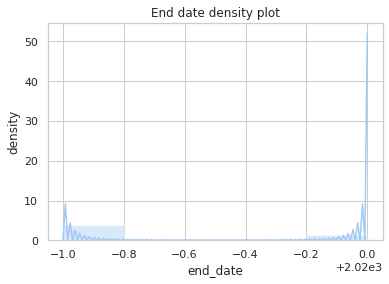

In [ ]:
distplot(df[df['end_date'] != TODAY_DATE]['end_date'].dt.year, bins = 5, title = 'End date density plot')

+ На графике выше мы видим, что действительно от нас начали уходить клиенты в последнее время. 

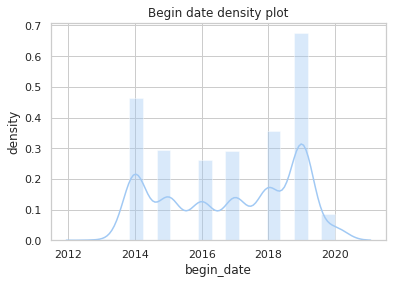

In [ ]:
distplot(df['begin_date'].dt.year, title = 'Begin date density plot')

+ В 2019 году видим рекордный прирост клиентов, не смотря на это в конце этого же года, начале следующего клиенты стали уходить.
+ Возможно **«Ниединогоразрыва.ком»** пообещали что-то клиентам в рекламной компании и не сдержали обещание.

### Числовые показатели

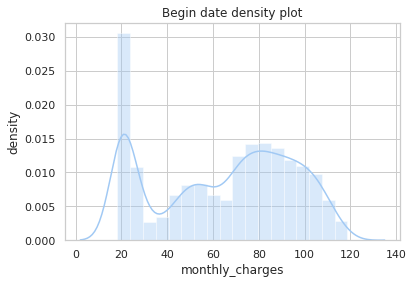

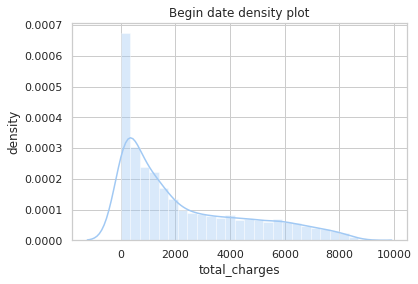

In [ ]:
for col in float_cols:
    distplot(df[col], title = 'Begin date density plot')

+ На графике `monthly_charges` видим би-модальное распределение. Вероятно это связано с различием в пакетах услуг.
+ График `total_charges` выглядит нормально, учитывая различие в пакетах услуг.

### Соотношения в категориальных признаках

#### Бинарные признаки

In [ ]:
binary_cols = ['paperless_billing', 'gender','senior_citizen', 'partner', 'dependents', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']

In [ ]:
def plot_pie(df, col):
    grouped = df.groupby(col)[col].count()
    data = grouped.values
    labels = grouped.index

    colors = sns.color_palette('pastel')[0:len(grouped)]

    plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
    plt.title(col + ' pie plot')
    plt.show()

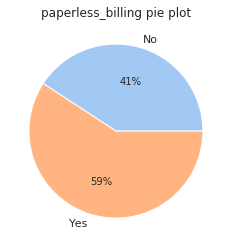

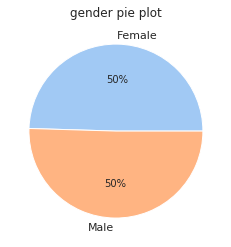

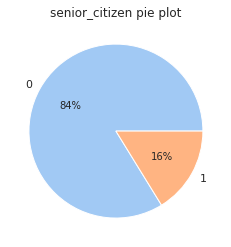

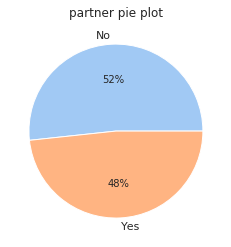

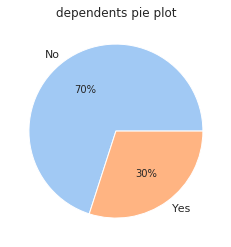

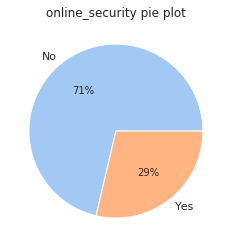

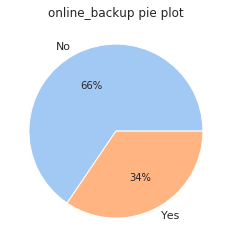

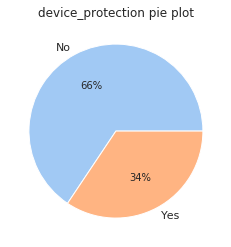

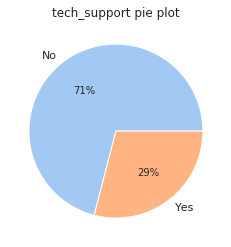

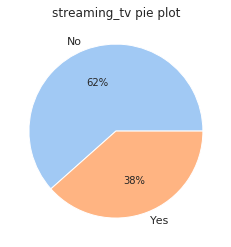

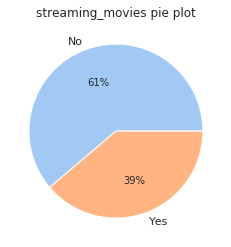

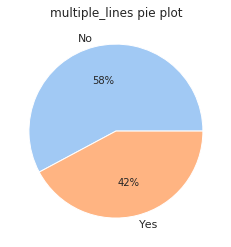

In [ ]:
for col in binary_cols:
    plot_pie(df, col)

+ Для бинарных признаков сильного дисбаланса/несоответствия не выявлено.
+ Сильный дисбаланс только в количестве пенсионеров, но это и понятно.

#### Признаки с несколькими категориями

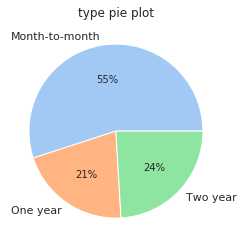

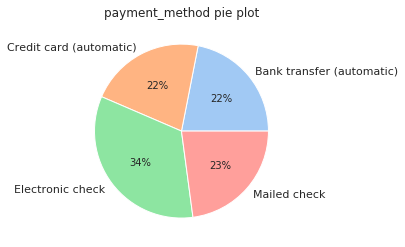

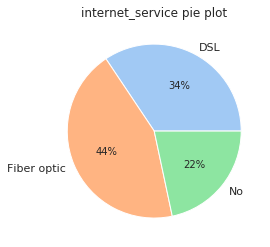

In [ ]:
multy_cat_cols = ['type', 'payment_method', 'internet_service']
for col in multy_cat_cols:
    plot_pie(df, col)

+ Большинство пользователей предпочитает помесячную оплату.
+ Способы оплаты распределены примерно равномерно, выделяется `Электронный платёж`.
+ Из интернета пользователи предпочитают `Оптоволокно` `Цифровой линии`.

#### Целевой признак

In [ ]:
df['exited'].value_counts()

0    5174
1    1869
Name: exited, dtype: int64

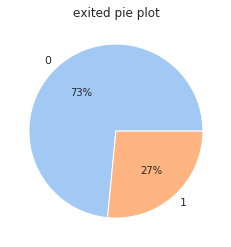

In [ ]:
plot_pie(df, 'exited')

+ Целевой признак несбалансирован. Будем пробовать различные техники борьбы с этим (upsampling / class_weights = balanced)

**Вывод:**
+ Мы загрузили данные, объединили их в один `DataFrame`, попутно заполнили появившиеся пропуски.
+ Привели типы данных к более подходящим.
+ Явных аномалий в `features` не выявлено.
+ Целевой признак не сбалансирован, нужно будет учитывать это при обучении моделей.

## План действий

+ **План действий:**  
    - Провести оценку важности `features`. Возможно добавить новые (время жизни клиента уже есть).  
    - Сделать OHE для моделей, которые не умеют работать с категориальными признаками.
    - Обезразмерить числовые данные, проверить как это влияет на метрику.
    - Разбить данные на обучающий и тестовый набор. Буду использовать кросс-валидацию, поэтому валидационный набор не нужен. (Помня про дисбаланс классов буду пробовать `upsampling` и `class_weights = balanced`)

    - Обучить простейшие классификаторы, посмотреть на результаты.   
    - Обучить различные модели на различных гиперпараметрах, подобрать наилучшие.  
    - Добиться наилучшего значения `ROC_AUC` на кросс валидации.
    - Провести тестирование модели и проверку на адекватность.
      
    - **Поблагодарить команду Я.Практикума за качественное обучение.**

## Обучение моделей

### Подготовка признаков

#### OHE

Для моделей, которые не умеют работать с категориальными признакми применим технику кодирования OHE.

In [ ]:
df_ohe = pd.get_dummies(df, columns = ['type', 'paperless_billing',
       'payment_method', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'], drop_first = True)

In [ ]:
df_ohe.head(3)

,id,begin_date,end_date,monthly_charges,total_charges,exited,tenure,type_One year,type_Two year,paperless_billing_Yes,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,senior_citizen_1,partner_Yes,dependents_Yes,internet_service_Fiber optic,internet_service_No,online_security_Yes,online_backup_Yes,device_protection_Yes,tech_support_Yes,streaming_tv_Yes,streaming_movies_Yes,multiple_lines_Yes
0,7590-VHVEG,2020-01-01,2020-02-01,29.85,29.85,0,31,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,5575-GNVDE,2017-04-01,2020-02-01,56.95,1889.50,0,1036,1,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01,53.85,108.15,1,61,0,0,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0


#### Корреляция признаков

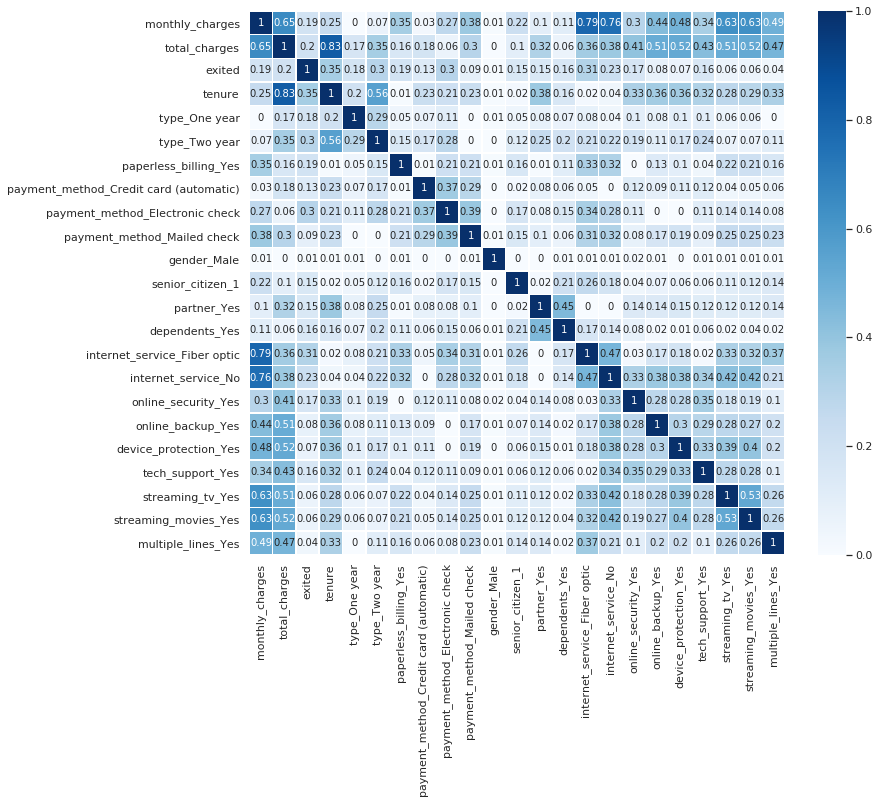

In [ ]:
corr = df_ohe.corr().abs().round(2)
fig, ax = plt.subplots(figsize=(12,10))

sns.heatmap(corr,
        yticklabels=corr.columns, annot=True, cmap="Blues", linewidths=.5, ax=ax)
plt.show()

+ Видим сильную корреляцию между Временем жизни клиента и Суммарными сборами. Это и понятно.
+ Также сильная корреляция между месячными сборами и набором пакетов услуг. Это тоже понятно.

Удалим прзнаки дат и id пользователя, а также признаки `total_charges` и `monthly_charges`.

In [ ]:
df_ohe = df_ohe.drop(['id', 'begin_date', 'end_date', 'total_charges', 'monthly_charges'], axis = 1)

#### Разделим данные на обучающий и тестовый набор

Мне нравится всегда использовать кросс валидацию, поэтому разделим данные только на обучающую и тестовую выборку.

In [ ]:
features = df.drop(['id', 'begin_date', 'end_date', 'exited', 'total_charges', 'monthly_charges'], axis = 1)
target = df['exited']

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.25, random_state = RANDOM_STATE)

In [ ]:
features_ohe = df_ohe.drop(['exited'], axis = 1)
target_ohe = df_ohe['exited']
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size = 0.25, random_state = RANDOM_STATE)

### Обучение моделей

In [ ]:
X = features_train_ohe
y = target_train_ohe

In [ ]:
def plot_features_scores(model, data, target, column_names, model_type):
    '''Функция для визуализации важности признаков'''
    
    model.fit(data, target)
    
    if model_type == 'rf':
        (pd.DataFrame(data = {'score': model['rf'].feature_importances_}, 
                      index = column_names).sort_values(by = 'score')
                                         .plot(kind = 'barh', grid = True,
                                               figsize = (6,6), legend = False));
    elif model_type == 'lr':
        (pd.DataFrame(data = {'score': model['lr'].coef_[0]},
                      index = column_names).sort_values(by = 'score')
                                         .plot(kind = 'barh', grid = True,
                                               figsize = (6,6), legend = False));
        
    else:
        raise KeyError('Unknown model_type')

In [ ]:
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state = RANDOM_STATE)

In [ ]:
def grid_search(model, gs_params, verbose = 0):
    '''Функция для подбора гиперпараметров с помощью перекрёстной проверки'''
     
    gs = GridSearchCV(estimator = model, param_grid = gs_params, refit = True,
                      scoring = 'roc_auc', n_jobs = -1, cv = skf, verbose = verbose)
    gs.fit(X, y)
    scores = [gs.cv_results_[f'split{i}_test_score'][gs.best_index_] for i in range(5)]
    print('ROC AUC scores = {}, \nROC AUC mean score = {:.5f} +/- {:.5f} \
           \nbest params = {}'.format(scores,
                                      gs.cv_results_['mean_test_score'][gs.best_index_],
                                      gs.cv_results_['std_test_score'][gs.best_index_],
                                      gs.best_params_))
    return gs

#### LogisticRegression

ROC AUC scores = [0.84908459 0.85901954 0.83416827 0.84731275 0.85388614] 
ROC AUC mean score = 0.84869 +/- 0.00833


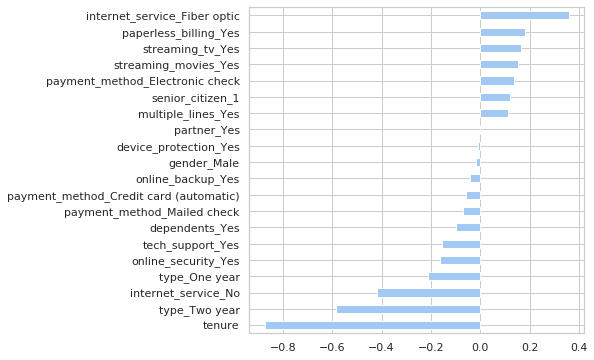

In [ ]:
lr = Pipeline([('p_trans', PowerTransformer(method = 'yeo-johnson', standardize=True)),
               ('lr', LogisticRegression(solver = 'liblinear',
                                         penalty = 'l1',
                                         max_iter = 200,
                                         class_weight = 'balanced',
                                         random_state = RANDOM_STATE)
               )])
scores = cross_val_score(estimator = lr, X = X, y = y, 
                         cv = skf, scoring = 'roc_auc', n_jobs = -1)
print('ROC AUC scores = {} \nROC AUC mean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

plot_features_scores(model = lr, data = X, target = y, column_names = X.columns, model_type = 'lr')

In [ ]:
#добавим селектор в пайплайн к логистической регрессии
selector = ('selector', GenericUnivariateSelect(score_func = mutual_info_classif, 
                                                mode = 'k_best'))
lr.steps.insert(0, selector)

    
# grid search
lr_params = {'selector__param': range(4, X.shape[1]),
             'lr__C': np.logspace(-3, 1.5, 3)}
print('Результаты для Логистической регрессии:')
lr_grid = grid_search(model = lr, gs_params = lr_params, verbose = 1)

Результаты для Логистической регрессии:
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  2.5min finished


ROC AUC scores = [0.8496351272908201, 0.8591139858657895, 0.8361472071149492, 0.847771734868509, 0.8545088867669511], 
ROC AUC mean score = 0.84944 +/- 0.00773            
best params = {'lr__C': 0.1778279410038923, 'selector__param': 19}


#### RandomForestClassifier

ROC AUC scores = [0.79833181 0.81475108 0.78946227 0.81444809 0.80541602] 
ROC AUC mean score = 0.80448 +/- 0.00969


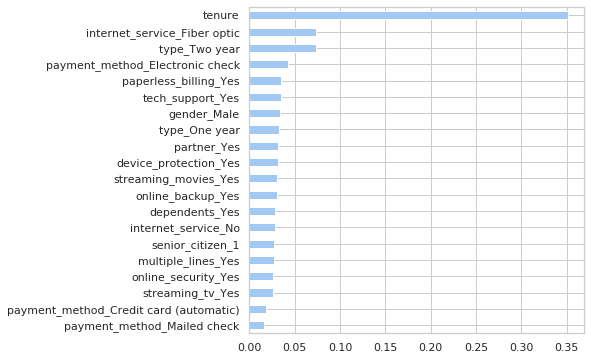

In [ ]:
rf = Pipeline([('rf', RandomForestClassifier(n_jobs=-1, 
                                             class_weight = 'balanced', 
                                             random_state = RANDOM_STATE))])

# параметры кросс-валидации (стратифицированная 5-фолдовая с перемешиванием) 

scores = cross_val_score(estimator = rf, X = X, y = y, 
                         cv = skf, scoring = 'roc_auc', n_jobs = -1)
print('ROC AUC scores = {} \nROC AUC mean score = {:.5f} +/- {:.5f}'.format(scores, scores.mean(), scores.std()))

# важность признаков
plot_features_scores(model = rf, data = X, target = y, column_names = X.columns, model_type = 'rf')

In [ ]:
# добавим селектор в пайплайн к случайному лесу
selector = ('selector', GenericUnivariateSelect(score_func = mutual_info_classif, 
                                                mode = 'k_best'))
rf.steps.insert(0, selector)

    
# grid search
rf_params = {'selector__param': np.arange(4, X.shape[1], 2),
             'rf__max_depth': np.arange(2, 10, 2),
             'rf__max_features': np.arange(0.3, 0.9, 0.3)}
print('Результаты для Случайного леса')
rf_grid = grid_search(model=rf, gs_params=rf_params, verbose = 1)

Результаты для Случайного леса
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  3.9min finished


ROC AUC scores = [0.8626152896407477, 0.8793248012088711, 0.8631119598861534, 0.8757051982858435, 0.8691756272401434], 
ROC AUC mean score = 0.86999 +/- 0.00667            
best params = {'rf__max_depth': 8, 'rf__max_features': 0.8999999999999999, 'selector__param': 8}


#### Catboost

In [ ]:
cat_features = ['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'multiple_lines']

In [ ]:
cv_data = features_train.to_numpy()
labels = target_train.values

cv_dataset = Pool(data = cv_data, label = labels, cat_features = cat_features, feature_names = features_train.columns.to_list())
params = {"iterations": 1000,
         "learning_rate": 0.09,
         "depth": 7,
         "eval_metric": 'AUC',
         "random_seed": RANDOM_STATE,
         "bagging_temperature": 0.2,
         "od_type": 'Iter',
         "metric_period": 1,
         "od_wait": 20}

scores = cv(cv_dataset, params, fold_count = 5, verbose = 50)
print('ROC AUC mean score = {:.5f} +/- {:.5f}'
      .format(scores['test-AUC-mean'].max(), 
              scores[scores['test-AUC-mean'] == scores['test-AUC-mean'].max()]['test-AUC-std'].values[0]))
cb_best_iter = scores[scores['test-AUC-mean'] == scores['test-AUC-mean'].max()]['iterations'].values[0]

0:	test: 0.8097121	best: 0.8097121 (0)	total: 321ms	remaining: 5m 20s
50:	test: 0.8625894	best: 0.8625894 (50)	total: 7.75s	remaining: 2m 24s
100:	test: 0.8686783	best: 0.8686783 (100)	total: 14.6s	remaining: 2m 10s
150:	test: 0.8805545	best: 0.8805545 (150)	total: 23.3s	remaining: 2m 11s
200:	test: 0.8896560	best: 0.8896560 (200)	total: 31.5s	remaining: 2m 5s
250:	test: 0.8971845	best: 0.8972380 (249)	total: 40s	remaining: 1m 59s
300:	test: 0.9022285	best: 0.9022285 (300)	total: 48.6s	remaining: 1m 52s
350:	test: 0.9065390	best: 0.9065390 (350)	total: 57.7s	remaining: 1m 46s
400:	test: 0.9102946	best: 0.9103583 (394)	total: 1m 6s	remaining: 1m 39s
450:	test: 0.9134027	best: 0.9134027 (450)	total: 1m 16s	remaining: 1m 33s
500:	test: 0.9153890	best: 0.9154827 (499)	total: 1m 26s	remaining: 1m 26s
550:	test: 0.9165349	best: 0.9165780 (547)	total: 1m 35s	remaining: 1m 17s
600:	test: 0.9177907	best: 0.9177907 (600)	total: 1m 44s	remaining: 1m 9s
650:	test: 0.9191758	best: 0.9191758 (650)	t

+ ROC AUC = 0.921 на кросс-валидации для модели Catboost.

**Вывод:** Наилучшей моделью оказалась модель Catboost. **ROC_AUC = 0.921** на кроссвалидации. Посмотрим дальше на результаты этой модели на тестовых данных.

### Тестирование модели

Обучим лучшую модель на всей тренировочной выборке.

In [ ]:
best_model = CatBoostClassifier(iterations = cb_best_iter, learning_rate = 0.09, depth = 7,
         eval_metric = 'AUC', random_seed = RANDOM_STATE, bagging_temperature = 0.2,
         od_type = 'Iter', metric_period = 1, od_wait = 20, cat_features = cat_features)
best_model.fit(features_train, target_train, verbose = 50)

0:	total: 7.72ms	remaining: 6.41s
50:	total: 1.57s	remaining: 24s
100:	total: 2.95s	remaining: 21.3s
150:	total: 4.63s	remaining: 20.9s
200:	total: 6.42s	remaining: 20.1s
250:	total: 8.21s	remaining: 19s
300:	total: 9.99s	remaining: 17.6s
350:	total: 12s	remaining: 16.4s
400:	total: 13.8s	remaining: 14.8s
450:	total: 15.6s	remaining: 13.2s
500:	total: 17.4s	remaining: 11.5s
550:	total: 20s	remaining: 10.2s
600:	total: 22.1s	remaining: 8.45s
650:	total: 24s	remaining: 6.62s
700:	total: 25.8s	remaining: 4.79s
750:	total: 27.6s	remaining: 2.94s
800:	total: 29.4s	remaining: 1.1s
830:	total: 30.6s	remaining: 0us


In [ ]:
print('Значение ROC AUC на тестовой выборке для лучшей модели: {:.5f}'.format(
    roc_auc_score(target_test, best_model.predict_proba(features_test)[:,1])))
print('Значение Accuracy на тестовой выборке для лучшей модели: {:.5f}'.format(
    accuracy_score(target_test, best_model.predict(features_test))))
print('Значение Precision на тестовой выборке для лучшей модели: {:.5f}'.format(
    precision_score(target_test, best_model.predict(features_test))))
print('Значение Recall на тестовой выборке для лучшей модели: {:.5f}'.format(
    recall_score(target_test, best_model.predict(features_test))))

Значение ROC AUC на тестовой выборке для лучшей модели: 0.92501
Значение Accuracy на тестовой выборке для лучшей модели: 0.88132
Значение Precision на тестовой выборке для лучшей модели: 0.83375
Значение Recall на тестовой выборке для лучшей модели: 0.69831


#### Roc Auc curve

In [ ]:
model_dummy = DummyClassifier(constant = 0)
model_dummy.fit(features_train, target_train)
predictions_test_dummy = model_dummy.predict(features_test)
probas_test_dummy = model_dummy.predict_proba(features_test)[:, 1]

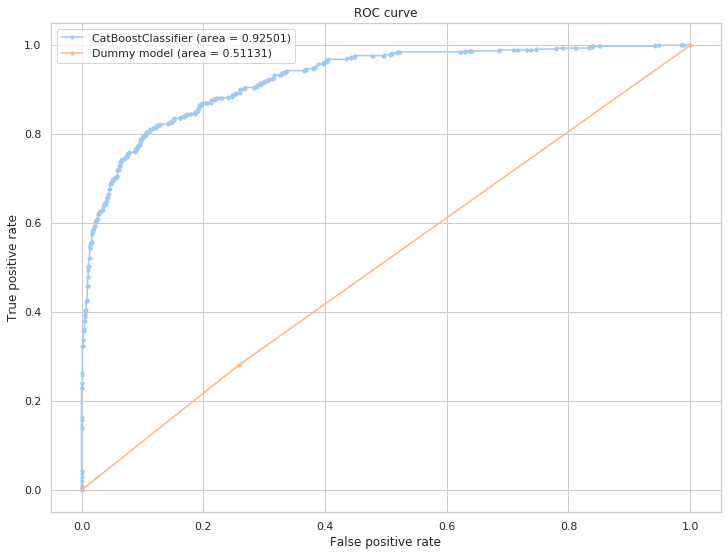

In [ ]:
def plot_roc_auc(model, features_test, target_test, plt_label):
    """
    Функция вычисляет вероятности для переданной модели и тестовых данных, вычисляет AUC value и строет ROC AUC кривую.
    """
    probs = model.predict_proba(features_test)[:, 1]
    auc = roc_auc_score(target_test, probs)
    fpr, tpr, thresholds = roc_curve(target_test, probs)
    plt.plot(fpr, tpr, marker='.', label = plt_label + ' (area = %0.5f)' % auc)

plt.rcParams['font.size'] = 16
plt.figure(figsize = (12, 9))   
plot_roc_auc(best_model, features_test, target_test, 'CatBoostClassifier')
plot_roc_auc(model_dummy, features_test, target_test, 'Dummy model')


plt.legend();
plt.xlabel('False positive rate'); 
plt.ylabel('True positive rate'); 
plt.title('ROC curve');
plt.show(); 

#### Матрица ошибок

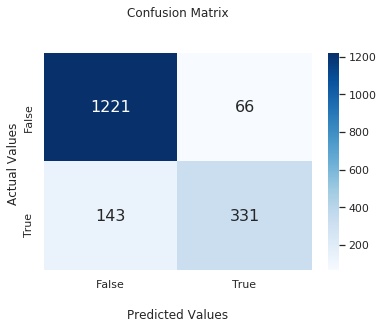

In [ ]:
cf_matrix = confusion_matrix(target_test, best_model.predict(features_test))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="")

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

**Вывод:** Наша модель предсказывает, очевидно, лучше модели константного выбора.  
+ **ROC AUC** на тестовой выборке для лучшей модели: **0.925**
  
+ *Accuracy* на тестовой выборке для лучшей модели: 0.881
+ *Precision* на тестовой выборке для лучшей модели: 0.833
+ *Recall* на тестовой выборке для лучшей модели: 0.698

## Отчёт

+ Какие пункты плана были выполнены, а какие — нет (поясните почему)?
  В принципе все пункты плана были выполнены, местами, объеденены или дополнены.
  + Во время работы над моделями я заметил сильную корреляцию признаков `monthly_charges` и `total_charges` с другими признаками. Целевая метрика получается лучше, если удалить оба.
  + Логистическая регрессия и леса обучались на OHE признаках, Catboost на категориальных.
  + Обезразмеривание данных проводилось только для Регрессии.
  + Лучшая модель была отобрана по результатам кросс-валидации. Upsampling я не стал делать. Ограничился `class_weights = balanced`.
  + Т.к. я никогда не использовал пайплайны, я решил попробовать их в финальном проекте. А так же завернуть подбор признаков в пайнплайн, всё получилось (только катбуст я не стал мучать, он и так хорошо работает). Поэтому обучение и подбор гиперпараметров у меня объеденились в один пункт.
  + Для подбора гиперпараметров исползовался grid_search в разрезе количества признаков у селектора.
  + Наилучшее значение **ROC AUC** **0.921** на кросс-валидации для модели Catboost.
  + Значение **ROC AUC** на тестовых данных составило **0.925**. Наша модель предсказывает, очевидно лучше тривиальной.  
  Accuracy: 0.881  
  Precision: 0.833  
  Recall: 0.698  
+ Какие трудности возникли и как вы их преодолели?  
  Мультриколлениарность признаков. Я посмотрел матрицу корреляции признаков, и удалил два признака, результаты улучшились, Catboost стал легче обучаться.
+ Какие ключевые шаги в решении задачи выделили?
  + Подготовка данных, заполнение пропусков, объединение.
  + Анализ данных, выделение целевого признака.
  + Отбор признаков для обучения.
  + Обучение моделей, подбор гиперпараметров.
  + Выбор лучшей модели, тестирование.
+ Какая ваша итоговая модель и какое у неё качество?
  + Лучшей моделью оказался Catboost.   </br>**ROC AUC: 0.921** на кросс-валидации и **0.925** на тестовых данных.  
  При этом **Accuracy**:  **0.881** на тестовых данных